# 🎓 **Applied Artificial Intelligence Master**

## 🤖 **Course: Fintech and Digital Innovation in Finance (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Lead Professor:** Marie-Ève Malette
#### 👩‍🏫 **Assistant Professor:** Yetnalezi Quintas Ruiz

### 📊 **Project 4 |  Section B: Advanced RAG techniques & Sentiment Analysis on S&P 500 news**

#### 📅 **August 13th, 2025**

#### **Student:**
* 🧑‍💻 Oscar Enrique García García (A01016093)

# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
%pip install hf_xet
%pip install yfinance
%pip install sentence-transformers

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [3]:
from google.colab import files

uploaded = files.upload()

Saving df_metadata.csv to df_metadata (1).csv
Saving df_news.csv to df_news (1).csv


In [4]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [5]:
df_meta = pd.read_csv('df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [6]:
from sentence_transformers import CrossEncoder

# Load the NLI model
nli_model = CrossEncoder("cross-encoder/nli-deberta-v3-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
def nli_sentiment_scores(headlines):
    """
    Compute POSITIVE_PROB, NEGATIVE_PROB, and SENTIMENT for each headline.
    """
    pos_hypothesis = "This is positive."
    neg_hypothesis = "This is negative."

    # Create pairs for NLI: premise=headline, hypothesis=sentiment statement
    pos_pairs = [(headline, pos_hypothesis) for headline in headlines]
    neg_pairs = [(headline, neg_hypothesis) for headline in headlines]

    # Model outputs logits for [contradiction, neutral, entailment]
    pos_preds = nli_model.predict(pos_pairs)
    neg_preds = nli_model.predict(neg_pairs)

    # Convert logits to probabilities (softmax)
    pos_probs = np.exp(pos_preds) / np.exp(pos_preds).sum(axis=1, keepdims=True)
    neg_probs = np.exp(neg_preds) / np.exp(neg_preds).sum(axis=1, keepdims=True)

    # Probability of entailment is index 2
    positive_prob = pos_probs[:, 2]
    negative_prob = neg_probs[:, 2]

    sentiment = positive_prob - negative_prob

    return positive_prob, negative_prob, sentiment


In [8]:
# Example: using the 'TITLE' column for sentiment
positive_prob, negative_prob, sentiment_score = nli_sentiment_scores(df_news["TITLE"].tolist())

df_news["POSITIVE_PROB"] = positive_prob
df_news["NEGATIVE_PROB"] = negative_prob
df_news["SENTIMENT"] = sentiment_score

In [9]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.987453,0.013937,0.973517
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.995787,0.988881,0.006906
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.998477,0.009877,0.988600
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.999765,0.996698,0.003067
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.977834,0.995446,-0.017611


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [10]:
df_news["PUBLICATION_DAY"] = pd.to_datetime(df_news["PUBLICATION_DATE"]).dt.tz_localize(None).dt.floor("D")


# Average sentiment per day
daily_sentiment = df_news.groupby("PUBLICATION_DAY")["SENTIMENT"].mean().reset_index()
daily_sentiment.rename(columns={"SENTIMENT": "AVG_SENTIMENT"}, inplace=True)

daily_sentiment.head()

,PUBLICATION_DAY,AVG_SENTIMENT
0,2024-07-12,-0.007379
1,2024-07-22,0.970245
2,2024-08-19,0.088648
3,2024-09-13,0.000035
4,2024-10-26,0.984635


In [11]:
import yfinance as yf

tickers = df_news["TICKER"].unique().tolist()

# Download adjusted close prices
price_data = yf.download(tickers, start=daily_sentiment["PUBLICATION_DAY"].min(),
                         end=daily_sentiment["PUBLICATION_DAY"].max(), auto_adjust=False)

# If multiple tickers, take the average price as "market proxy"
if isinstance(price_data, pd.DataFrame):
    price_data["MARKET_AVG"] = price_data.mean(axis=1)
else:
    price_data = price_data.to_frame(name="MARKET_AVG")

[*********************100%***********************]  487 of 487 completed
/tmp/ipython-input-1044906633.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data["MARKET_AVG"] = price_data.mean(axis=1)


In [12]:
market_returns = price_data["MARKET_AVG"].pct_change().dropna()
market_returns = market_returns.reset_index()
market_returns.rename(columns={"Date": "PUBLICATION_DAY", "MARKET_AVG": "DAILY_RETURN"}, inplace=True)
market_returns.head()

,PUBLICATION_DAY,DAILY_RETURN
0,2024-07-15,-0.026501
1,2024-07-16,0.024505
2,2024-07-17,0.262180
3,2024-07-18,-0.070937
4,2024-07-19,-0.090015


In [13]:
df_compare = pd.merge(daily_sentiment, market_returns, on="PUBLICATION_DAY", how="inner")
df_compare.head()

,PUBLICATION_DAY,AVG_SENTIMENT,DAILY_RETURN
0,2024-07-22,0.970245,-0.064841
1,2024-08-19,0.088648,-0.092639
2,2024-09-13,0.000035,-0.139660
3,2024-11-12,0.003189,-0.055169
4,2024-12-11,0.000413,0.033042


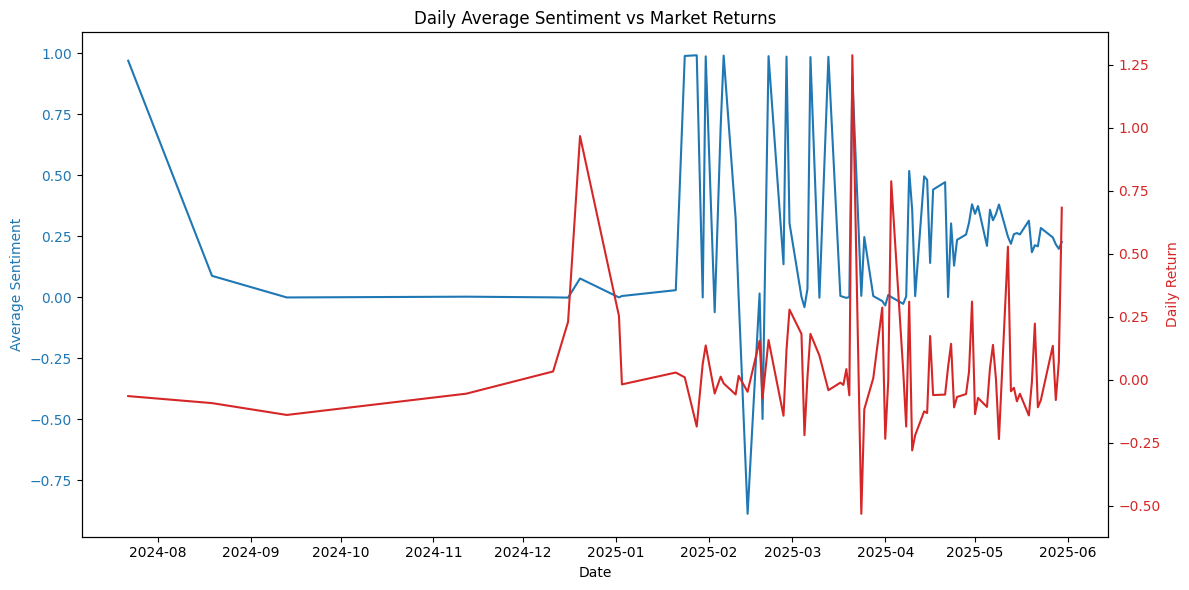

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sentiment
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="tab:blue")
ax1.plot(df_compare["PUBLICATION_DAY"], df_compare["AVG_SENTIMENT"], color="tab:blue", label="Avg Sentiment")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for returns
ax2 = ax1.twinx()
ax2.set_ylabel("Daily Return", color="tab:red")
ax2.plot(df_compare["PUBLICATION_DAY"], df_compare["DAILY_RETURN"], color="tab:red", label="Daily Return")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout
plt.title("Daily Average Sentiment vs Market Returns")
fig.tight_layout()
plt.show()


## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


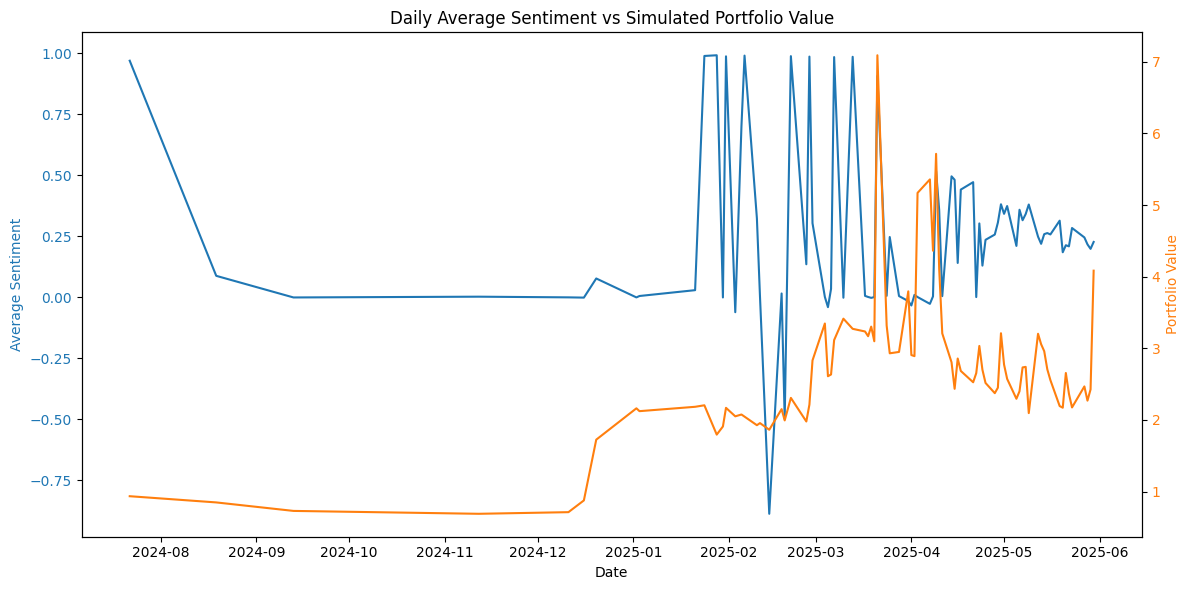

In [15]:
# Compute Portfolio Value (start at 1)
df_compare["Portfolio Value"] = (1 + df_compare["DAILY_RETURN"]).cumprod()

# Plot Sentiment vs Portfolio Value
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: daily average sentiment
ax1.plot(df_compare["PUBLICATION_DAY"], df_compare["AVG_SENTIMENT"], color="tab:blue", label="Avg Sentiment")
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right y-axis: simulated portfolio value
ax2 = ax1.twinx()
ax2.plot(df_compare["PUBLICATION_DAY"], df_compare["Portfolio Value"], color="tab:orange", label="Portfolio Value")
ax2.set_ylabel("Portfolio Value", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Daily Average Sentiment vs Simulated Portfolio Value")
fig.tight_layout()
plt.show()


## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [16]:
MAY_PERIOD = pd.Period("2025-05", "M")

In [17]:
news = df_news.copy()
news["PUBLICATION_DATE"] = pd.to_datetime(news["PUBLICATION_DATE"], errors="coerce")
news = news.merge(df_meta[["TICKER", "SECTOR"]], on="TICKER", how="left")

# Monthly average sentiment per sector
news["YM"] = news["PUBLICATION_DATE"].dt.to_period("M")
monthly_sector_sentiment = (
    news.groupby(["SECTOR", "YM"])["SENTIMENT"]
        .mean()
        .reset_index()
)

monthly_sector_sentiment.head()

/tmp/ipython-input-884943462.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  news["YM"] = news["PUBLICATION_DATE"].dt.to_period("M")


,SECTOR,YM,SENTIMENT
0,Basic Materials,2025-01,0.667093
1,Basic Materials,2025-02,-0.114953
2,Basic Materials,2025-03,0.288597
3,Basic Materials,2025-04,0.197456
4,Basic Materials,2025-05,0.312180


In [18]:
# Target months
MONTHS = pd.PeriodIndex(["2025-02","2025-03","2025-04","2025-05"], freq="M")

# Filter to target months
sent_feb_may_sector = (
    monthly_sector_sentiment[
        monthly_sector_sentiment["YM"].isin(MONTHS)
    ].copy()
)

# Compute average sentiment by sector for each month
avg_sentiment_sector = (
    sent_feb_may_sector.groupby(["SECTOR", "YM"])["SENTIMENT"]
        .mean()
        .reset_index()
        .rename(columns={"SENTIMENT": "AVG_SENTIMENT"})
)

# Convert YM (Period) to timestamp for plotting later
#avg_sentiment_sector["YM"] = avg_sentiment_sector["YM"].dt.to_timestamp("M")

display(avg_sentiment_sector.head(12))

,SECTOR,YM,AVG_SENTIMENT
0,Basic Materials,2025-02,-0.114953
1,Basic Materials,2025-03,0.288597
2,Basic Materials,2025-04,0.197456
3,Basic Materials,2025-05,0.312180
4,Communication Services,2025-03,0.015375
5,Communication Services,2025-04,0.211529
6,Communication Services,2025-05,0.204507
7,Consumer Cyclical,2025-02,-0.332790
8,Consumer Cyclical,2025-03,-0.009642
9,Consumer Cyclical,2025-04,0.091782


In [19]:
may_sentiment = (
    monthly_sector_sentiment.loc[monthly_sector_sentiment["YM"] == MAY_PERIOD, ["SECTOR", "SENTIMENT"]]
    .rename(columns={"SENTIMENT": "SENTIMENT_MAY"})
    .reset_index(drop=True)
)

may_sentiment.head()

,SECTOR,SENTIMENT_MAY
0,Basic Materials,0.312180
1,Communication Services,0.204507
2,Consumer Cyclical,0.220057
3,Consumer Defensive,0.202022
4,Energy,0.235367


In [20]:
may_headlines = (
    news.loc[news["YM"] == MAY_PERIOD]
        .groupby("SECTOR")["SENTIMENT"]
        .size()
        .rename("HEADLINES_MAY")
        .reset_index()
)

may_headlines.head()

,SECTOR,HEADLINES_MAY
0,Basic Materials,135
1,Communication Services,144
2,Consumer Cyclical,409
3,Consumer Defensive,270
4,Energy,172


In [21]:
def extract_close_panel(price_df, tickers=None):
    """
    Returns a DataFrame with index=dates (tz-naive), columns=tickers, values=Close (Adj Close preferred).
    Handles yfinance MultiIndex variants:
      - (field, ticker) e.g., ('Adj Close','AAPL')
      - (ticker, field) (less common)
      - ('Price', field, ticker) e.g., ('Price','Close','AAPL')
    """
    df = price_df.copy()

    # Infer tickers if not provided
    if tickers is None:
        if isinstance(df.columns, pd.MultiIndex):
            # Try to pull tickers from the last level
            tickers = sorted(set(df.columns.get_level_values(-1)))
        else:
            # single ticker case; leave as None
            pass

    if isinstance(df.columns, pd.MultiIndex):
        lv0 = df.columns.get_level_values(0)
        lv1 = df.columns.get_level_values(1) if df.columns.nlevels >= 2 else pd.Index([])
        # Case A: (field, ticker)
        if "Adj Close" in lv0:
            out = df["Adj Close"]
        elif "Close" in lv0:
            out = df["Close"]
        # Case B: (ticker, field)
        elif "Close" in lv1:
            out = df.xs("Close", axis=1, level=1)
        elif "Adj Close" in lv1:
            out = df.xs("Adj Close", axis=1, level=1)
        # Case C: ('Price', field, ticker) like your screenshot
        elif ("Price" in lv0) and ("Close" in lv1):
            out = df.xs(("Price", "Close"), axis=1, level=[0, 1])
        else:
            raise ValueError("Could not locate Close/Adj Close in yfinance output.")
    else:
        # Single-index columns (likely single ticker)
        if "Adj Close" in df.columns:
            out = df[["Adj Close"]]
        elif "Close" in df.columns:
            out = df[["Close"]]
        else:
            raise ValueError("No 'Adj Close' or 'Close' in single-index yfinance frame.")

        # If we know the single ticker, name the column accordingly
        if out.shape[1] == 1 and tickers and len(tickers) == 1:
            out.columns = [tickers[0]]

    # TZ-naive index
    out.index = pd.to_datetime(out.index).tz_localize(None)

    return out

In [22]:
close_panel = extract_close_panel(price_data, tickers=df_news["TICKER"].unique().tolist())

# Monthly close, then monthly % returns per ticker
close_m = close_panel.resample("M").last()
ret_m = close_m.pct_change()

# Map tickers -> sector and average tickers within each sector
sector_map = (
    df_meta[["TICKER", "SECTOR"]]
    .dropna()
    .drop_duplicates()
    .set_index("TICKER")["SECTOR"]
    .to_dict()
)

# Keep only tickers we can map
common = [t for t in ret_m.columns if t in sector_map]
ret_m = ret_m[common].copy()

# Robust aggregation to sector level
ret_m_sector = (
    ret_m.T
        .assign(SECTOR=lambda x: x.index.map(sector_map))
        .groupby("SECTOR")
        .mean()
        .T
)

# Make sure the index can be interpreted as monthly periods
idx_month = pd.PeriodIndex(pd.to_datetime(ret_m_sector.index), freq="M")

may_mask = (idx_month == MAY_PERIOD)

may_returns = (
    ret_m_sector.loc[may_mask]
    .T.squeeze()                      # sectors as rows
    .rename("RETURN_MAY")
    .reset_index()
    .rename(columns={"index": "SECTOR"})
    .reset_index(drop=True)
)

may_returns.head()

/tmp/ipython-input-2863435919.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  close_m = close_panel.resample("M").last()


,SECTOR,RETURN_MAY
0,Basic Materials,0.029613
1,Communication Services,0.041527
2,Consumer Cyclical,0.056382
3,Consumer Defensive,0.000008
4,Energy,0.029434


In [23]:
comparison_table = (
    may_sentiment
        .merge(may_headlines, on="SECTOR", how="left")
        .merge(may_returns,  on="SECTOR", how="inner")
)

# Pearson correlation (May sentiment vs May returns)
if not comparison_table.empty and comparison_table[["SENTIMENT_MAY", "RETURN_MAY"]].notna().all().all():
    corr = comparison_table[["SENTIMENT_MAY", "RETURN_MAY"]].corr(method="pearson").iloc[0, 1]
else:
    corr = np.nan

print(f"Correlation (May 2025 sentiment vs May 2025 returns): {corr:.3f}")
display(comparison_table.sort_values("RETURN_MAY", ascending=False))

Correlation (May 2025 sentiment vs May 2025 returns): -0.269


,SECTOR,SENTIMENT_MAY,HEADLINES_MAY,RETURN_MAY
9,Technology,0.275274,636,0.075285
7,Industrials,0.237436,539,0.073894
5,Financial Services,0.225462,453,0.061068
2,Consumer Cyclical,0.220057,409,0.056382
1,Communication Services,0.204507,144,0.041527
10,Utilities,0.292018,209,0.032967
0,Basic Materials,0.312180,135,0.029613
4,Energy,0.235367,172,0.029434
8,Real Estate,0.359962,188,0.010360
6,Healthcare,0.278522,446,0.000100


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


Real State and Basic Materials were the best-looking in sentiment in May 2025; however, the performance in returns was not so good (only 0.02 and 0.01 respectively). We can conclude with this that sentiment not always shows us an accurate result on investing plans.

### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


Technology, Industrial and Financial services was the top-3 in returnings on May 2025, despite we can see that sentiment score was relatively low (more neutral).



### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

No — as we could see on previous answers, sentiment alone is not a reliable indicator for investing plans.

The correlation for May sentiment vs returns is negative (-0.269).
Several high-sentiment sectors (e.g., Real Estate, Basic Materials) underperformed.

Market performance depends on many factors (earnings, macro trends, sector rotation, historical prices, news, etc.) beyond media tone.

### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

For a more robust strategy testing a sentiment analysis we could apply the following

- Longer time frame: Test across multiple years, not just one month.
- Rolling correlation: See if the sentiment-return relationship changes over time.
- Lagged analysis: Test whether sentiment leads returns over the time.
- Portfolio simulation: Build long/short portfolios based on sentiment ranks and track performance vs benchmarks.
- Sector vs ticker level: Compare results at both the sector and individual stock level.
- Risk adjustment: Evaluate Sharpe ratio, drawdowns, and volatility, not just raw returns.
- Cross-validation: Use walk-forward testing to avoid lookahead bias.